# Appendix B Portfolio solution

This notebook illustrates the numerical computation for portofio choice solution discussed in appendix B.

For the results in Section 5, we solved the HJB equation numerically. While we posed the HJB
equation in Section 5 using $\Sigma_t$ as a state variable, our computations start from a single initialization.
Given the initial $\Sigma_0$, $\Sigma_t$ is strictly decreasing in t. Thus, for computational purposes, we
express the value function in terms $t$ instead of $\Sigma_t$; and solve the corresponding PDE. We derive
this transformed PDE in the remainder of this appendix.



We guess the value function as 

$$
K(x, z, t) = x + K_0(t) + \frac{1}{2} K_2(t) (z - r)^2
$$

Coefficient of $(z-r)^2$ gives rise to the following differential equation:

$$
0 = \frac{d K_2(t)}{ dt} + \frac{1}{\gamma |B_y|^2 + \alpha \Sigma_t} - \delta K_2(t) - 2 \frac{\frac{\Sigma_t}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} K_2(t) -  \frac{\frac{\Sigma_t^2}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} K_2(t)^2
$$

The remaining terms give rise to the following differential equation:

$$
0 = \frac{d K_0(t)}{ dt}  - \delta K_0(t) + \delta \log \delta - \delta + r + \frac{1}{2} K_2(t) \frac{\Sigma_t^2}{|B_y|^2}
$$

We will use two terminal conditions to address the above ODEs.

- **Terminal condition 1**:
    T = 100, 000, and $K_2(T)$, $K_0(T)$ satisfy:
    
    $$ 0 = \frac{1}{\gamma |B_y|^2} - \delta K_2(T) $$

    and
    
    $$ 0 = \delta \log \delta - \delta + r - \delta K_0(T) $$
    
- **Terminal condition 2**:
    T = 25 and and $K_2(T)$, $K_0(T)$ satisfy:
    
    $$ K_2(T) = K_0 (T) = 0 $$
    


To solve the ODEs numerically, we discretize the ODE in the following way:

$$
\begin{aligned}
\frac{ {\color{red}{K_2(t)}} - {\color{red}{K_2(t -1)}} }{ dt} &= -\frac{1}{\gamma |B_y|^2 + \alpha \Sigma_t} + \delta {\color{red}{K_2(t)}} + 2 \frac{\frac{\Sigma_t}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} {\color{red}{K_2(t)}} +  \frac{\frac{\Sigma_t^2}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} {\color{red}{K_2(t)}}^2\\
\frac{{\color{red}{K_0(t)}} - {\color{red}{K_0(t-1)}}}{ dt}  &= \delta {\color{red}{K_0(t)}} - \delta \log \delta + \delta - r - \frac{1}{2} K_2 \frac{\Sigma_t^2}{|B_y|^2}
\end{aligned}
$$

with

$$
\Sigma_t = \frac{|B_y|^2 \Sigma_0}{t \Sigma_0 + |B_y|^2}
$$

and we solve $K_2(t)$ and $K_0(t)$ iteratively from $T$ to $t = 0$

## Parameters

By default, the values of the parameters being used in our computation are as follows:

| Parameters | Values|
|------| ----|
| $\delta$ | $0.01$|
| $\gamma$ | $5$ |
| $\alpha$ | $0$ |
| $B_y$ | $0.18$ |
| $r$ | $0.02$ |
| $\Sigma_0$ | $0.1^2$|
| $T$ | 25 |

We would also expriment with alternative choices of $\alpha = 3,6$ and $\Sigma_0 = 0.05^2, 0.25^2$.

By default, we use **terminal condition 2** if not noted otherwise.

In [1]:
import numpy as np
from numba import njit
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.framealpha"] = 0.5

In [2]:
Σ0 = 0.1**2
B_y = 0.18
γ = 5
α = 0
δ = 0.01
r = 0.02
T = 25
dt = 0.1

In [3]:
time = np.arange(0, T+dt, dt)
Σt = B_y**2 * Σ0 / (time * Σ0 + B_y**2)

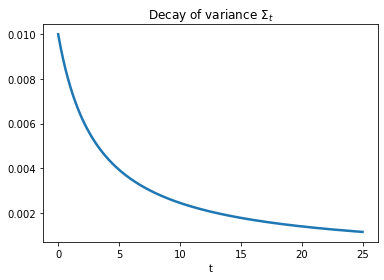

In [4]:
plt.plot(time, Σt)
plt.title("Decay of variance $\Sigma_t$")
plt.xlabel("t")
plt.show()

In [5]:
@njit
def limiting_K2(args):
    Σ0, B_y, γ, α, δ, r = args
    return 1 / (δ * γ * B_y**2)

@njit
def limiting_K0(args):
    Σ0, B_y, γ, α, δ, r = args
    return np.log(δ) - 1 + r / δ 

In [6]:
@njit
def simulate_Σ(T, dt, args):
    time = np.arange(0, T+dt, dt)
    Σ0, B_y, γ, α, δ, r = args
    Σt = B_y**2 * Σ0 / (time * Σ0 + B_y**2)
    return Σt

@njit
def simulate_K2(Σt, T, dt, args, limitingTerm=False):
    Σ0, B_y, γ, α, δ, r = args
    adjust = (γ - 1) * B_y**2 + α * Σt
    denominator =  γ * B_y**2 + α * Σt
    # K2
    K2 = np.zeros_like(Σt)
    T_max = len(K2) - 1
    if limitingTerm:
        K2[-1] = limiting_K2(args)
    for i in range(1, K2.shape[0]):
        K2[T_max - i] = K2[T_max-i+1]
        K2[T_max - i] += 1 / denominator[T_max-i+1] * dt
        K2[T_max - i] -= δ * K2[T_max-i+1] * dt
        K2[T_max - i] -= 2 * Σt[T_max-i+1] / B_y**2 * adjust[T_max-i+1] / denominator[T_max-i+1] * K2[T_max-i+1] * dt
        K2[T_max - i] -= Σt[T_max-i+1] **2 / B_y**2 * adjust[T_max-i+1] / denominator[T_max-i+1] * K2[T_max-i+1]**2 * dt
    
    return K2


@njit
def simulate_K0(T, dt, args, limitingTerm=False):
    Σ0, B_y, γ, α, δ, r = args
    Σt = simulate_Σ(T, dt, args)
    K2 = simulate_K2(Σt, T, dt, args, limitingTerm)
    adjust = (γ - 1) * B_y**2 + α * Σt
    denominator =  γ * B_y**2 + α * Σt
    T_max = Σt.shape[0] - 1
    # K1
    K0 = np.zeros_like(Σt)
    if limitingTerm:
        K0[-1] = limiting_K0(args)
    for i in range(1, K0.shape[0]):
        K0[T_max - i] = K0[T_max - i + 1] - δ * K0[T_max - i + 1] * dt
        K0[T_max - i] += (δ * np.log(δ) - δ + r) * dt
        K0[T_max - i] += 1/2 * K2[T_max-i+1] * Σt[T_max - i + 1]**2 / B_y**2 * dt
        
    return K2, K0

In [7]:
Σt = simulate_Σ(T, dt, args=(Σ0, B_y, γ, α, δ, r))
K2, K0 = simulate_K0(T, dt, args=(Σ0, B_y, γ, α, δ, r))
K24, K04 = simulate_K0(T, dt, args=(Σ0, B_y, γ, 3., δ, r))
K28, K08 = simulate_K0(T, dt, args=(Σ0, B_y, γ, 6., δ, r))
K2h, K0h = simulate_K0(T, dt, args=(0.25**2, B_y, γ, α, δ, r))
K24h, K04h = simulate_K0(T, dt, args=(0.25**2, B_y, γ, 3., δ, r))
K28h, K08h = simulate_K0(T, dt, args=(0.25**2, B_y, γ, 6., δ, r))
K2l, K0l = simulate_K0(T, dt, args=(0.05**2, B_y, γ, α, δ, r))
K24l, K04l = simulate_K0(T, dt, args=(0.05**2, B_y, γ, 3., δ, r))
K28l, K08l = simulate_K0(T, dt, args=(0.05**2, B_y, γ, 6., δ, r))

The solutions are illustration in the following plot: 

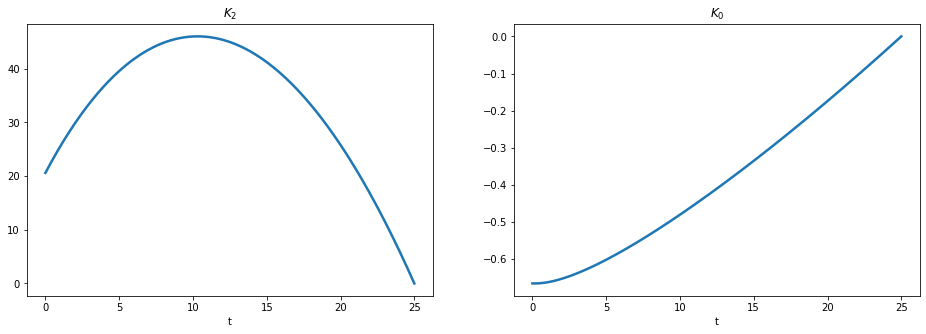

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1.plot(time, K2, label="$K_2$")
ax1.set_xlabel("t")
ax1.set_title("$K_2$")

ax2.plot(time, K0, label="$K_0$")
ax2.set_xlabel("t")
ax2.set_title("$K_0$")
plt.show()

## Portfolio choice and expected excess return

We decompose the optimal portofolio choice $\psi^*$ into myopic demand and hedging demand:
$$
 \psi^* = \underbrace{\frac{z-r}{\gamma |B_y|^2 + \alpha \Sigma_t}}_\text{myopic}\quad \underbrace{-  K_2 (z -r) \frac{\Sigma_t}{|B_y|^2} \left(\frac{(\gamma-1) |B_y|^2 + \alpha \Sigma_t}{\gamma |B_y|^2 + \alpha \Sigma_t}  \right)}_\text{hedging}
$$

We illustrate hedging demand, myopic demand and total demand in terms of expected excess return, $z - r$, at time $t =  0$.


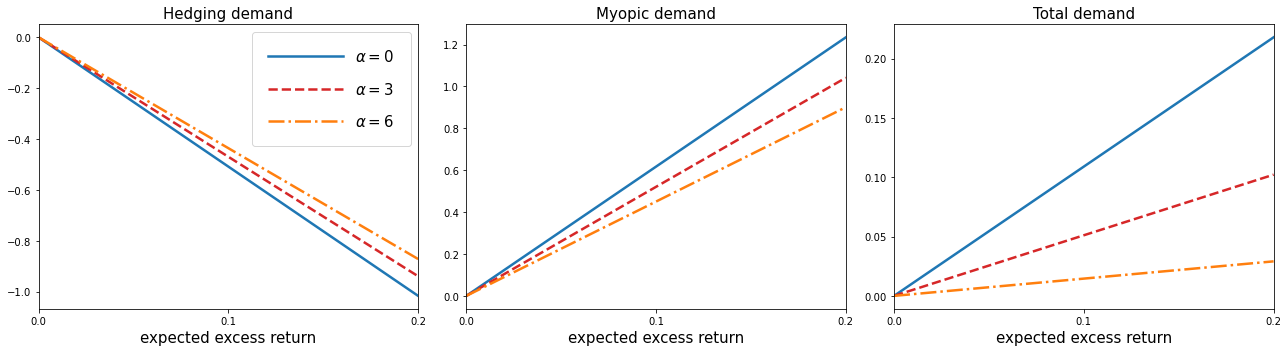

In [9]:
γ = 5
T = 25
αs = [0,  3 , 6]
Σt = simulate_Σ(T, 0.1, args=(Σ0, B_y, γ, αs[0], δ, r))
excess_return = np.linspace(0, 0.2)


def myopic(excess_r, args):
    Σ0, B_y, γ, α, δ, r = args
    return excess_r / (γ * B_y**2 + α * Σ0)

def hegding(excess_r, k2, args):
    Σ0, B_y, γ, α, δ, r = args
    adjust = (γ - 1) * B_y**2 + α * Σ0
    temp = - k2 * excess_r * Σ0 / B_y**2 * adjust 
    temp /= γ * B_y**2 + α * Σ0
    return temp

myopic0 = myopic(excess_return, args=(Σt[0], B_y, γ, αs[0], δ, r))
myopic1 = myopic(excess_return, args=(Σt[0], B_y, γ, αs[1], δ, r))
myopic2 = myopic(excess_return, args=(Σt[0], B_y, γ, αs[2], δ, r))

hedging0 = hegding(excess_return, K2[0], args=(Σt[0], B_y, γ, αs[0], δ, r))
hedging1 = hegding(excess_return, K24[0], args=(Σt[0], B_y, γ, αs[1], δ, r))
hedging2 = hegding(excess_return, K28[0], args=(Σt[0], B_y, γ, αs[2], δ, r))

fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))

ax1.plot(excess_return,  hedging0, label="$\\alpha = 0$")
ax1.plot(excess_return,  hedging1, label="$\\alpha = 3$", color="C3", linestyle="--")
ax1.plot(excess_return,  hedging2, label="$\\alpha = 6$", color="C1", linestyle="-.")
ax1.set_title("Hedging demand", fontsize=15)

ax2.plot(excess_return, myopic0, label="$\\alpha = 0$")
ax2.plot(excess_return, myopic1, label="$\\alpha = 3$", color="C3", linestyle="--")
ax2.plot(excess_return, myopic2, label="$\\alpha = 6$", color="C1", linestyle="-.")
ax2.set_title("Myopic demand", fontsize=15)

ax3.plot(excess_return, myopic0 +  hedging0, label="$\\alpha = 0$")
ax3.plot(excess_return, myopic1 +  hedging1, label="$\\alpha = 3$", color="C3", linestyle="--")
ax3.plot(excess_return, myopic2 +  hedging2, label="$\\alpha = 6$", color="C1", linestyle="-.")
ax3.set_title("Total demand", fontsize=15)

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([0.0, 0.1, 0.2])
    ax.set_xlim(0.0, 0.2)
    ax.set_xlabel("expected excess return", fontsize=15)
ax1.legend(fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
    
    
plt.tight_layout()
plt.show()

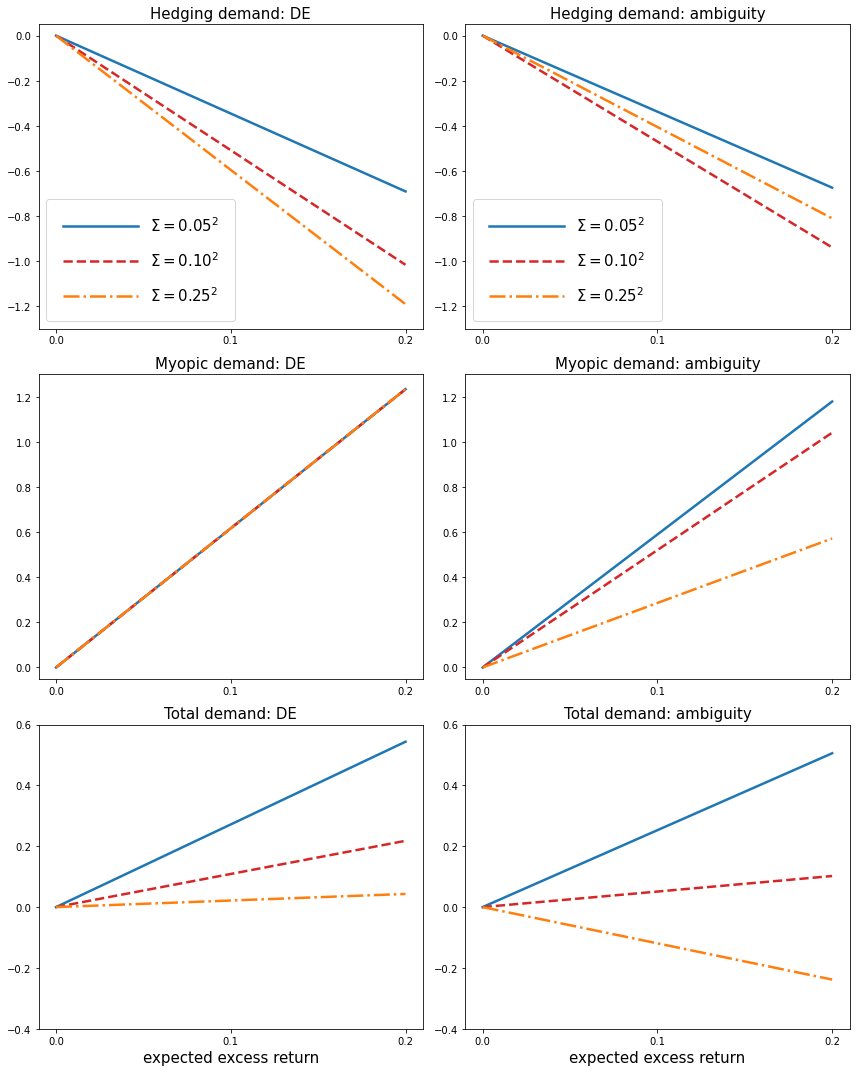

In [10]:
fig, axes = plt.subplots(3,2, figsize=(12, 15))

# γ = 5
# DE
## hedging
α = αs[0]
axes[0,0].plot(excess_return, hegding(excess_return, K2l[0], args=(0.05**2, B_y, γ, α, δ, r)), color="C0")
axes[0,0].plot(excess_return, hegding(excess_return, K2[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[0,0].plot(excess_return, hegding(excess_return, K2h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[0,0].set_title("Hedging demand: DE", fontsize=15)
## myopic
axes[1,0].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)))
axes[1,0].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[1,0].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[1,0].set_title("Myopic demand: DE", fontsize=15)
## total
axes[2,0].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K2l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[2,0].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)) 
               + hegding(excess_return, K2[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[2,0].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K2h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[2,0].set_title("Total demand: DE", fontsize=15)

# ambiguity
α = αs[1]
## hedging
axes[0,1].plot(excess_return, hegding(excess_return, K24l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[0,1].plot(excess_return, hegding(excess_return, K24[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[0,1].plot(excess_return, hegding(excess_return, K24h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[0,1].set_title("Hedging demand: ambiguity", fontsize=15)
## myopic
axes[1,1].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)))
axes[1,1].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[1,1].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[1,1].set_title("Myopic demand: ambiguity", fontsize=15)
## total
axes[2,1].plot(excess_return, myopic(excess_return, args=(0.05**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K24l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[2,1].plot(excess_return, myopic(excess_return, args=(Σt[0], B_y, γ, α, δ, r)) 
               + hegding(excess_return, K24[0], args=(Σt[0], B_y, γ, α, δ, r)), color="C3", linestyle="--")
axes[2,1].plot(excess_return, myopic(excess_return, args=(0.25**2, B_y, γ, α, δ, r)) 
               + hegding(excess_return, K24h[0], args=(0.25**2, B_y, γ, α, δ, r)), color="C1", linestyle="-.")
axes[2,1].set_title("Total demand: ambiguity", fontsize=15)


for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i,j].set_xticks([0,0.1,0.2])
axes[0,0].legend(["$\\Sigma=0.05^2$", "$\\Sigma=0.10^2$","$\\Sigma=0.25^2$",], fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
axes[0,1].legend(["$\\Sigma=0.05^2$", "$\\Sigma=0.10^2$","$\\Sigma=0.25^2$",], fontsize=15, framealpha=0.8,  handlelength=5, borderpad=1.1, labelspacing=1.1)
axes[2,0].set_xlabel("expected excess return", fontsize=15)
axes[2,1].set_xlabel("expected excess return", fontsize=15)

axes[0,0].set_ylim(-1.3, 0.05)
axes[0,1].set_ylim(-1.3, 0.05)

axes[1,0].set_ylim(-0.05, 1.3)
axes[1,1].set_ylim(-0.05, 1.3)

axes[2,0].set_ylim(-0.4, 0.6)
axes[2,1].set_ylim(-0.4, 0.6)
plt.tight_layout()

As demands are proportional to $z-r$, we report in Table 1 and Table 2 the slope of demand with different choices of parameters and terminal conditions.

The slope of hedging demand is given by:
$$
K_2 \frac{\frac{\Sigma}{B_y^2}[(\gamma - 1) + \alpha \frac{\Sigma}{B_y^2}]}{\gamma + \alpha \frac{\Sigma}{B_y^2}}
$$

The slope of myopic demand is given by:
$$
\frac{1}{\gamma |B_y|^2 + \alpha \Sigma_t}
$$

The slope of total demand is just the sum of the two slopes above.

Tables 1 and 2 give the slopes of the portfolio rules depicted in Figures 1 and 2, respectively, in comparison to the slopes implied by the infinite-horizon problem. The total demand slopes are lower for the infinite-horizon problem with the $\alpha=6$ slope actually negative. See Table 1. 

The hedging demand remains non-monotone under ambiguity aversion as we vary $Σ_0$ for the infinite-horizon problem. See Table 2(b) for $\alpha=3$.

In [11]:
def myopic_slope(args):
    Σ0, B_y, γ, α, δ, r = args
    return 1 / (γ * B_y**2 + α * Σ0)

def hedging_slope(k2, args):
    Σ0, B_y, γ, α, δ, r = args
    adjust = (γ - 1) * B_y**2 + α * Σ0
    temp = - k2 * Σ0 / B_y**2 * adjust 
    temp /= γ * B_y**2 + α * Σ0
    return temp

def total_slope(k2, args):
    Σ0, B_y, γ, α, δ, r = args
    my_sl = myopic_slope(args)
    hed_sl = hedging_slope(k2, args)
    return my_sl + hed_sl

In [12]:
# table 1
γ = 5
Σ = 0.1**2
Alphas = [0, 3, 6]

temp = []
for alpha in Alphas:
    hed_temp = []
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    hed_Miao = hedging_slope(k2_Miao[0], args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    hed_Hansen = hedging_slope(k2_Hansen[0], args=(Σ, B_y, γ, alpha, δ, r))
    hed_temp.append(hed_Hansen)
    hed_temp.append(hed_Miao)
    temp.append(hed_temp)
    
for alpha in Alphas:
    my_temp = []  
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    my_Miao = myopic_slope(args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    my_Hansen = myopic_slope(args=(Σ, B_y, γ, alpha, δ, r))
    my_temp.append(my_Hansen)
    my_temp.append(my_Miao)
    temp.append(my_temp)
    
for alpha in Alphas:
    total_temp = []
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    total_Miao = total_slope(k2_Miao[0], args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    total_Hansen = total_slope(k2_Hansen[0], args=(Σ, B_y, γ, alpha, δ, r))
    total_temp.append(total_Hansen)
    total_temp.append(total_Miao)
    temp.append(total_temp)

data1 = np.round(temp,3)
contents = ["Hedging demand", "Myopic demand", "Total demand"]
ids = pd.MultiIndex.from_product([contents, ['\(\\alpha = 0\)', '\(\\alpha = 3\)', "\(\\alpha = 6\)"]])
tab1 = pd.DataFrame(data1, index=ids, columns=["\(\textbf{TC 1}\)", "\(\textbf{TC 2}\)"])
print("Table 1: γ = 5, and Σ_0 = 0.1^2")
tab1

Table 1: γ = 5, and Σ_0 = 0.1^2


\(\textbf{TC 1}\)  \(\textbf{TC 2}\)
Hedging demand \(\alpha = 0\)             -5.529             -5.084
               \(\alpha = 3\)             -5.136             -4.698
               \(\alpha = 6\)             -4.789             -4.359
Myopic demand  \(\alpha = 0\)              6.173              6.173
               \(\alpha = 3\)              5.208              5.208
               \(\alpha = 6\)              4.505              4.505
Total demand   \(\alpha = 0\)              0.644              1.089
               \(\alpha = 3\)              0.073              0.511
               \(\alpha = 6\)             -0.284              0.145

In [13]:
# table 2(a)
γ = 5
alpha = 0

temp = []
for Σ in [0.05**2, 0.10**2, 0.25**2]:
    hed_temp = []
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    hed_Miao = hedging_slope(k2_Miao[0], args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    hed_Hansen = hedging_slope(k2_Hansen[0], args=(Σ, B_y, γ, alpha, δ, r))
    hed_temp.append(hed_Hansen)
    hed_temp.append(hed_Miao)
    temp.append(hed_temp)
    
for Σ in [0.05**2, 0.10**2, 0.25**2]:
    my_temp = []  
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    my_Miao = myopic_slope(args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    my_Hansen = myopic_slope(args=(Σ, B_y, γ, alpha, δ, r))
    my_temp.append(my_Hansen)
    my_temp.append(my_Miao)
    temp.append(my_temp)
    
for Σ in [0.05**2, 0.10**2, 0.25**2]:
    total_temp = []
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    total_Miao = total_slope(k2_Miao[0], args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    total_Hansen = total_slope(k2_Hansen[0], args=(Σ, B_y, γ, alpha, δ, r))
    total_temp.append(total_Hansen)
    total_temp.append(total_Miao)
    temp.append(total_temp)

data2a = np.round(temp,3)
contents = ["Hedging demand", "Myopic demand", "Total demand"]
ids = pd.MultiIndex.from_product([contents, ['\(Σ_0 = 0.05^2\)', '\(Σ_0 = 0.10^2\)', "\(Σ_0 = 0.25^2\)"]])
tab2a = pd.DataFrame(data2a, index=ids, columns=["\(\textbf{TC 1}\)", "\(\textbf{TC 2}\)"])
print("Table 2(a): DE(α=0)")
tab2a

Table 2(a): DE(α=0)


\(\textbf{TC 1}\)  \(\textbf{TC 2}\)
Hedging demand \(Σ_0 = 0.05^2\)             -4.585             -3.455
               \(Σ_0 = 0.10^2\)             -5.529             -5.084
               \(Σ_0 = 0.25^2\)             -6.028             -5.957
Myopic demand  \(Σ_0 = 0.05^2\)              6.173              6.173
               \(Σ_0 = 0.10^2\)              6.173              6.173
               \(Σ_0 = 0.25^2\)              6.173              6.173
Total demand   \(Σ_0 = 0.05^2\)              1.588              2.718
               \(Σ_0 = 0.10^2\)              0.644              1.089
               \(Σ_0 = 0.25^2\)              0.145              0.216

In [14]:
# table 2(b)
γ = 5
alpha = 3

temp = []
for Σ in [0.05**2, 0.10**2, 0.25**2]:
    hed_temp = []
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    hed_Miao = hedging_slope(k2_Miao[0], args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    hed_Hansen = hedging_slope(k2_Hansen[0], args=(Σ, B_y, γ, alpha, δ, r))
    hed_temp.append(hed_Hansen)
    hed_temp.append(hed_Miao)
    temp.append(hed_temp)
    
for Σ in [0.05**2, 0.10**2, 0.25**2]:
    my_temp = []  
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    my_Miao = myopic_slope(args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    my_Hansen = myopic_slope(args=(Σ, B_y, γ, alpha, δ, r))
    my_temp.append(my_Hansen)
    my_temp.append(my_Miao)
    temp.append(my_temp)
    
for Σ in [0.05**2, 0.10**2, 0.25**2]:
    total_temp = []
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    total_Miao = total_slope(k2_Miao[0], args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    total_Hansen = total_slope(k2_Hansen[0], args=(Σ, B_y, γ, alpha, δ, r))
    total_temp.append(total_Hansen)
    total_temp.append(total_Miao)
    temp.append(total_temp)

data2b = np.round(temp,3)
contents = ["Hedging demand", "Myopic demand", "Total demand"]
ids = pd.MultiIndex.from_product([contents, ['\(Σ_0 = 0.05^2\)', '\(Σ_0 = 0.10^2\)', "\(Σ_0 = 0.25^2\)"]])
tab2b = pd.DataFrame(data2b, index=ids, columns=["\(\textbf{TC 1}\)", "\(\textbf{TC 2}\)"])
print("Table 2(b): Ambiguity(α={})".format(alpha))
tab2b

Table 2(b): Ambiguity(α=3)


\(\textbf{TC 1}\)  \(\textbf{TC 2}\)
Hedging demand \(Σ_0 = 0.05^2\)             -4.491             -3.372
               \(Σ_0 = 0.10^2\)             -5.136             -4.698
               \(Σ_0 = 0.25^2\)             -4.118             -4.052
Myopic demand  \(Σ_0 = 0.05^2\)              5.900              5.900
               \(Σ_0 = 0.10^2\)              5.208              5.208
               \(Σ_0 = 0.25^2\)              2.861              2.861
Total demand   \(Σ_0 = 0.05^2\)              1.408              2.528
               \(Σ_0 = 0.10^2\)              0.073              0.511
               \(Σ_0 = 0.25^2\)             -1.257             -1.191

Table 3 below applies the distorted conditional mean return formula, namely formula (31) in the paper,

$$
\begin{equation}
\overline{Z}_t - \alpha \Sigma_t \left[ \psi^* \left(\overline{Z}_t - r, \Sigma_t \right) + J_2\left( \Sigma_t \right) \left(\overline{Z}_t - r \right) \frac{\Sigma_t}{|B_y|^2} \right]
\end{equation}
$$

to computes the proportional reduction in the expected excess return under the implied worst-case probabilities. Table 3 reports the implied slope (as a function of $\overline{Z}_t-r$) of the worst-case increment:

$$
\begin{equation}
\alpha \Sigma_t \left[ \psi^* \left(\overline{Z}_t - r, \Sigma_t \right) + J_2\left( \Sigma_t \right) \left(\overline{Z}_t - r \right) \frac{\Sigma_t}{|B_y|^2} \right]
\end{equation}
$$

This adjustment lowers the expected excess return by about twenty percent for $\alpha=3$, and by a little over thirty percent for $\alpha=6$ when $\Sigma_0 = .01$. As can be seen by the numbers reported in table, this conclusion is not very sensitive to whether we limit the decision horizon to be twenty-five years or allow it to be infinite.


In [15]:
# table 3

def distortion_slope(k2, args):
    Σ0, B_y, γ, α, δ, r = args
    ψ_slope = total_slope(k2[0], args)
    res = α*Σ0*(ψ_slope + k2[0]*Σ0/B_y**2)
    return res

γ = 5
Σ = 0.1**2
Alphas = [3, 6]

temp = []
for alpha in Alphas:
    distortion_temp = []
    k2_Miao, _ = simulate_K0(25, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=False)
    distortion_Miao = distortion_slope(k2_Miao, args=(Σ, B_y, γ, alpha, δ, r))
    k2_Hansen, _ = simulate_K0(100_000, 0.1, args=(Σ, B_y, γ, alpha, δ, r), limitingTerm=True)
    distortion_Hansen = distortion_slope(k2_Hansen, args=(Σ, B_y, γ, alpha, δ, r))
    distortion_temp.append(distortion_Hansen)
    distortion_temp.append(distortion_Miao)
    temp.append(distortion_temp)

data3 = np.round(temp,3)
ids = ["α=3", "α=6"]
tab3 = pd.DataFrame(data3, index=ids, columns=["\(\textbf{TC 1}\)", "\(\textbf{TC 2}\)"])
print("Table 3")
tab3

Table 3


,\(\textbf{TC 1}\),\(\textbf{TC 2}\)
α=3,0.188,0.185
α=6,0.319,0.315


## Solving for $J_2 (\Sigma_t)$ and $J_0(\Sigma_t)$

While the appendix computes continuation values by replacing $s = \Sigma_t$ by $t$, the functions $J_0$
and $J_2$ can be inferred from the infinite-horizon solution described in this appendix, by noting that $J_2(0) = K_2(\infty)$, $J_0(0) = K_0(\infty)$, and using the formula $\frac{d\Sigma_t}{dt} = -\frac{\Sigma_t^2}{|B_y|^2}$.

Below, we write down the differential equation in terms of $J_2(\Sigma_t)$ and demonstrate how to solve for $J_2(\Sigma_t)$, and compare it with $K_2(t)$:

$$
\frac{d {\color{red}{J_2(\Sigma_t)}} }{ dt} = \frac{d {\color{red}{J_2(\Sigma_t)}} }{ d\Sigma} \left(- \frac{\Sigma_t^2}{|B_y|^2}\right) = -\frac{1}{\gamma |B_y|^2 + \alpha \Sigma_t} + \delta {\color{red}{J_2(\Sigma_t)}} + 2 \frac{\frac{\Sigma_t}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} {\color{red}{J_2(\Sigma_t)}} +  \frac{\frac{\Sigma_t^2}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} {\color{red}{J_2(\Sigma_t)}}^2
$$

A way comparable to solve $K_2(t)$ with **terminal condition 1** is to solve the above system with the following initial condition:

$$
0 = \frac{1}{\gamma |B_y|^2} - \delta J_2(0)
$$

In [16]:
@njit
def solve_J2(Σt, initial, args):
    Σ0, B_y, γ, α, δ, r = args
# initial = (True, _)
# args= (Σ0, B_y, γ, α, δ, r)
# N = 100
#     Σ = np.arange(Σ_min, Σ0 + Σ_min, Δ)
    Σ = np.flip(Σt)
    Δ = Σ[1:] - Σ[:-1]
    N = Σ.shape[0] -1
    J2 = np.zeros_like(Σ)
    adjust = (γ - 1) * B_y**2 + α * Σ
    denominator =  γ * B_y**2 + α * Σ
    if initial[0]:
        J2[0] = limiting_K2(args)
        temp = J2[0] * (- Σ[0]**2 / B_y**2)
        for i in range(1, N + 1):
            mu = - 1/(γ * B_y**2 + α * Σ[i-1]) + δ * J2[i-1]
            mu +=  2 * Σ[i-1] / B_y**2 * adjust[i-1] / denominator[i-1] * J2[i-1]
            mu +=  Σ[i-1] **2 / B_y**2 * adjust[i-1] / denominator[i-1] * J2[i-1]**2
            mu *= - B_y**2 / Σ[i-1]**2
            J2[i] = J2[i-1] + mu * Δ[i-1]
#             J2[i] = temp * ( - B_y**2 / Σ[i]**2)
    else:
        J2[-1] = initial[1]
        for i in range(1, N + 1):
            mu = - 1/(γ * B_y**2 + α * Σ[N-i+1]) + δ * J2[N-i+1]
            mu +=  2 * Σ[N -i+1] / B_y**2 * adjust[N-i+1] / denominator[N-i+1] * J2[N-i+1]
            mu +=  Σ[N-i+1] **2 / B_y**2 * adjust[N-i+1] / denominator[N-i+1] * J2[N-i+1]**2
            mu *= - B_y**2 / Σ[N-i+1]**2
            J2[N-i] = J2[N-i+1] - mu * Δ[N-i+1]

    return J2, Σ, Δ

In [17]:
γ = 5
α = 0
sigma = simulate_Σ(1_00_000, 0.1, args=(Σ0, B_y, γ, α, δ, r))
kk2, kk0 = simulate_K0(1_00_000, 0.1, args=(Σ0, B_y, γ, α, δ, r), limitingTerm=True)
sigma_25 = simulate_Σ(25, 0.01, args=(Σ0, B_y, γ, α, δ, r))
k2, k0 = simulate_K0(25, 0.01, args=(Σ0, B_y, γ, α, δ, r))
j2, Σ, Δ = solve_J2(sigma, initial=(True, kk2[0]), args= (Σ0, B_y, γ, α, δ, r))
jj2, ΣΣ, ΔΔ = solve_J2(sigma, initial=(False, kk2[0]), args= (Σ0, B_y, γ, α, δ, r))

A result comparison is illustrated below. 
For the orange dashed line, we solve $K_2(t)$ with **terminal condition 1**, and plot it in terms of $\Sigma_t$.
We can see that the two solutions are very close.

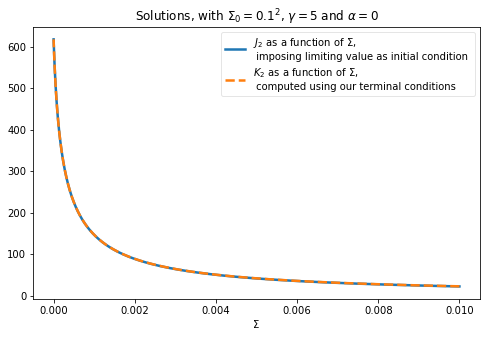

In [18]:
plt.figure(figsize=(8,5))
plt.plot(Σ, j2, label="$J_2$ as a function of $\Sigma$, \n imposing limiting value as initial condition ")
plt.plot(sigma, kk2, label="$K_2$ as a function of $\Sigma$, \n computed using our terminal conditions", linestyle="dashed")
plt.legend(loc=1)
plt.xlabel("Σ")
plt.title("Solutions, with $Σ_0 = 0.1^2$, $γ= 5$ and $α = 0$")
plt.show()